# Causal Demand Shock Attribution System

## Problem Statement
Traditional demand forecasting systems detect changes in demand but fail to explain
*why* those changes occurred.

This project aims to:
- Detect abnormal demand changes
- Separate natural demand patterns (trend & seasonality)
- Attribute demand shocks to external causal factors such as:
  - Promotions
  - Price changes
  - Supply disruptions
  - External events

## Objective
Build a system that not only flags demand anomalies but also explains the most
likely causes behind each demand shock.


## Causal Factors Considered

The following external factors are modeled as potential causes of demand shocks:

- Promotions (marketing campaigns, discounts)
- Price changes
- Supply disruptions
- Special events

Each factor is represented as a time-aligned feature and used to explain
observed demand deviations.


## Data Sources

1. Historical demand time-series data
2. External event data aligned by date
3. Engineered temporal features (lags, rolling statistics)

All datasets are structured to allow causal attribution modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Create date range
dates = pd.date_range(start="2022-01-01", end="2022-12-31", freq="D")

# Base demand pattern
trend = np.linspace(50, 80, len(dates))
seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
noise = np.random.normal(0, 4, len(dates))

# Final demand
demand = trend + seasonality + noise

df_demand = pd.DataFrame({
    "date": dates,
    "demand": demand
})

df_demand.set_index("date", inplace=True)
df_demand.head()


,demand
date,
2022-01-01,52.158990
2022-01-02,49.873576
2022-01-03,53.271786
2022-01-04,57.027396
2022-01-05,50.252705


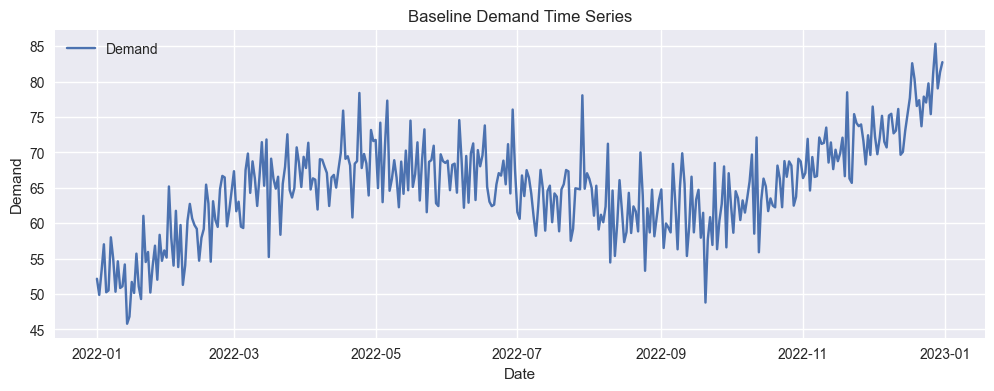

In [3]:
plt.figure(figsize=(12,4))
plt.plot(df_demand.index, df_demand["demand"], label="Demand")
plt.title("Baseline Demand Time Series")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


In [4]:
event_data = pd.DataFrame({
    "date": [
        "2022-02-10",
        "2022-03-05",
        "2022-04-01",
        "2022-06-15",
        "2022-09-10"
    ],
    "event_type": [
        "promotion",
        "supply_issue",
        "price_drop",
        "promotion",
        "supply_issue"
    ],
    "intensity": [0.8, 0.6, 0.4, 0.9, 0.7]
})

event_data["date"] = pd.to_datetime(event_data["date"])
event_data


,date,event_type,intensity
0,2022-02-10,promotion,0.8
1,2022-03-05,supply_issue,0.6
2,2022-04-01,price_drop,0.4
3,2022-06-15,promotion,0.9
4,2022-09-10,supply_issue,0.7


In [5]:
df = df_demand.merge(event_data, how="left", left_index=True, right_on="date")

df["event_type"] = df["event_type"].fillna("none")
df["intensity"] = df["intensity"].fillna(0)

df.set_index("date", inplace=True)
df.head(10)


,demand,event_type,intensity
date,,,
2022-01-01,52.158990,none,0.0
2022-01-02,49.873576,none,0.0
2022-01-03,53.271786,none,0.0
2022-01-04,57.027396,none,0.0
2022-01-05,50.252705,none,0.0
2022-01-06,50.506557,none,0.0
2022-01-07,58.013437,none,0.0
2022-01-08,55.019450,none,0.0
2022-01-09,50.324531,none,0.0


In [6]:
df.to_csv("../data/raw_demand.csv")
print("Raw demand data saved successfully.")


Raw demand data saved successfully.


In [7]:
# Temporal lag features
df['demand_lag_1'] = df['demand'].shift(1)
df['demand_lag_7'] = df['demand'].shift(7)
df['demand_lag_14'] = df['demand'].shift(14)


In [8]:
# Rolling statistics
df['rolling_mean_7'] = df['demand'].rolling(window=7).mean()
df['rolling_std_7'] = df['demand'].rolling(window=7).std()

df['rolling_mean_14'] = df['demand'].rolling(window=14).mean()
df['rolling_std_14'] = df['demand'].rolling(window=14).std()

# Z-score (contextual abnormality)
df['z_score_7'] = (df['demand'] - df['rolling_mean_7']) / df['rolling_std_7']


In [9]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['demand'], period=7)
result = stl.fit()

df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid


In [10]:
# Trend change indicator
df['trend_change'] = df['trend'].diff()

# Absolute shock magnitude
df['shock_strength'] = abs(df['residual'])


## Final Feature Set for Causal Modeling

The following features are used as inputs for anomaly detection and causal attribution models:

- `demand`: Observed demand value
- `demand_lag_1`, `demand_lag_7`, `demand_lag_14`: Temporal memory of recent demand behavior
- `rolling_mean_7`, `rolling_std_7`: Local baseline statistics capturing short-term normal behavior
- `z_score_7`: Standardized deviation from recent baseline
- `residual`: Demand component unexplained by trend and seasonality
- `trend_change`: Indicator of structural shifts in long-term demand
- `shock_strength`: Magnitude of unexpected external disturbance

Each feature is designed to capture a specific causal signal, enabling explainable demand shock attribution.


In [11]:
df.dropna(inplace=True)
df.head()


,demand,event_type,intensity,demand_lag_1,demand_lag_7,demand_lag_14,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,z_score_7,trend,seasonal,residual,trend_change,shock_strength
date,,,,,,,,,,,,,,,,
2022-01-15,46.807708,none,0.0,45.805035,55.019450,52.158990,50.526539,3.334374,51.975048,3.550438,-1.115301,50.766372,-0.758133,-3.200531,-0.001155,3.200531
2022-01-16,51.706695,none,0.0,46.807708,50.324531,49.873576,50.723991,3.361233,52.105986,3.500426,0.292364,50.971607,-0.547624,1.282712,0.205235,1.282712
2022-01-17,50.152181,none,0.0,51.706695,54.624930,53.271786,50.085027,2.887879,51.883157,3.519745,0.023254,51.427850,-1.029004,-0.246665,0.456243,0.246665
2022-01-18,55.707300,none,0.0,50.152181,50.852772,57.027396,50.778531,3.598448,51.788864,3.386492,1.369693,52.057217,2.084786,1.565297,0.629367,1.565297
2022-01-19,51.064117,none,0.0,55.707300,51.094719,50.252705,50.774159,3.598018,51.846822,3.365055,0.080588,52.759686,-0.356731,-1.338838,0.702469,1.338838


In [12]:
df.reset_index().to_csv("../data/causal_features.csv", index=False)
print("Saved causal_features.csv")


Saved causal_features.csv
